In [1]:

from pathlib import Path
import os

# Path.cwd().chdir('../')
os.chdir('../')
print(Path.cwd())

/scratch/students/jiaxunliu/historical-map


## GPU boost query

In [2]:
# # Copyright (c) Meta Platforms, Inc. and affiliates.
# #
# # This source code is licensed under the MIT license found in the
# # LICENSE file in the root directory of this source tree.

# import numpy as np

# d = 64                           # dimension
# nb = 100000                      # database size
# nq = 10000                       # nb of queries
# np.random.seed(1234)             # make reproducible
# xb = np.random.random((nb, d)).astype('float32')
# xb[:, 0] += np.arange(nb) / 1000.
# xq = np.random.random((nq, d)).astype('float32')
# xq[:, 0] += np.arange(nq) / 1000.

# import faiss                     # make faiss available

# res = faiss.StandardGpuResources()  # use a single GPU

# ## Using a flat index

# index_flat = faiss.IndexFlatL2(d)  # build a flat (CPU) index

# # make it a flat GPU index
# gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)

# gpu_index_flat.add(xb)         # add vectors to the index
# print(gpu_index_flat.ntotal)

# k = 4                          # we want to see 4 nearest neighbors
# D, I = gpu_index_flat.search(xq, k)  # actual search
# print(I[:5])                   # neighbors of the 5 first queries
# print(I[-5:])                  # neighbors of the 5 last queries


# ## Using an IVF index

# nlist = 100
# quantizer = faiss.IndexFlatL2(d)  # the other index
# index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
# # here we specify METRIC_L2, by default it performs inner-product search

# # make it an IVF GPU index
# gpu_index_ivf = faiss.index_cpu_to_gpu(res, 0, index_ivf)

# assert not gpu_index_ivf.is_trained
# gpu_index_ivf.train(xb)        # add vectors to the index
# assert gpu_index_ivf.is_trained

# gpu_index_ivf.add(xb)          # add vectors to the index
# print(gpu_index_ivf.ntotal)

# k = 4                          # we want to see 4 nearest neighbors
# D, I = gpu_index_ivf.search(xq, k)  # actual search
# print(I[:5])                   # neighbors of the 5 first queries
# print(I[-5:])                  # neighbors of the 5 last queries

## GPT written way to train my own data

In [3]:
# import pickle
# with open('result/info_dict_new.pickle', 'rb') as f:
#     info_dict = pickle.load(f)

In [4]:
import numpy as np
import faiss
import torch
from pipeline.utils import *

info_dict = load_info_dict()
#generate the matrix
# image_embeddings = torch.stack( [info['image_embedding'] for info in id_info_list])
# text_embeddings = torch.stack( [info['text_embedding'] for info in id_info_list])
id_info_list = load_id_info_list(info_dict)
image_embeddings = load_image_embeddings(info_dict)
text_embeddings = load_text_embeddings(info_dict)
# Prepare your dataset
data = np.array(image_embeddings.cpu(), dtype=np.float32)  # Replace [...] with your data
d = data.shape[1]  # Dimensionality
# nlist = 100  # Number of clusters
nlist = int(4 * np.sqrt(data.shape[0]))  # Results in nlist = 4000


# Initialize the quantizer and index
quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

# Train the index
index.train(data)

# Add data to the index
index.add(data)

# Perform a search
k = 4                          # we want to see 4 nearest neighbors
index.nprobe = 10
query_vectors = image_embeddings[10:15].cpu()
# Reshape the query vector to have shape (1, d)
# query_vectors = query_vectors.reshape(1, -1)
D, I = index.search(query_vectors, k)  # 'query_vectors' is your query data


WARNING clustering 476 points to 87 centroids: please provide at least 3393 training points


In [5]:
(D,I)

(array([[1.        , 0.87220156, 0.83090883, 0.8258081 ],
        [1.0000002 , 0.94828725, 0.9342857 , 0.92831147],
        [0.99999976, 0.899112  , 0.7904804 , 0.78410065],
        [1.        , 0.93889827, 0.93070614, 0.92084897],
        [1.        , 0.88448507, 0.8486177 , 0.82790524]], dtype=float32),
 array([[ 10,  18,   7,   9],
        [ 11,   8, 424,   1],
        [ 12,   2, 463, 436],
        [ 13,  19, 326, 437],
        [ 14,   3, 360, 350]]))

In [10]:
from pipeline.ImageBind import *

text = 'compass'
pipeline_ib = ImageBindPipeline()
text_embeddings = pipeline_ib.generate_word_embedding(np.array([text]))


In [11]:
text_embeddings = text_embeddings['text']
# index.add(text_embeddings.detach().cpu())
D,I = index.search(np.array(text_embeddings.detach().cpu()),10)
(D,I)

(array([[33.33629 , 32.888386, 31.271639, 30.692831, 30.615364, 29.51186 ,
         29.381607, 28.739094, 28.469738, 26.509718]], dtype=float32),
 array([[181, 170, 174, 399, 177, 387, 171, 219, 178, 187]]))

[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >
 <Axes: > <Axes: >]


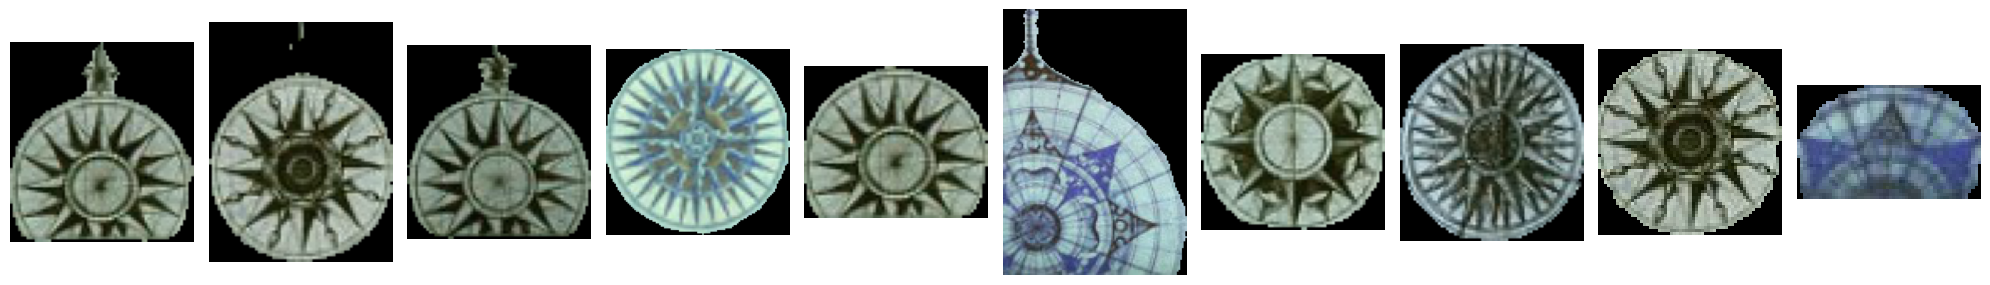

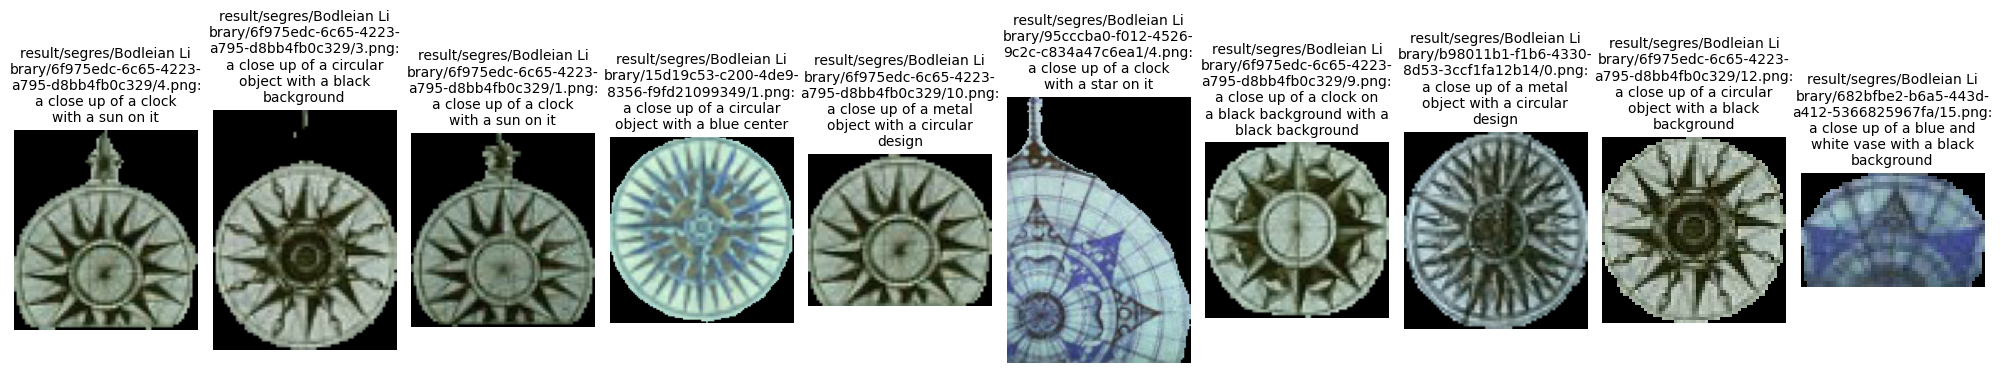

In [12]:
show_results([ info['path'] for info in np.array(id_info_list)[I[0]] ])
show_results_with_text([ info['path'] for info in np.array(id_info_list)[I[0]] ], info_dict)


In [13]:
[ info['path'] for info in np.array(id_info_list)[I[0]] ]

['result/segres/Bodleian Library/6f975edc-6c65-4223-a795-d8bb4fb0c329/4.png',
 'result/segres/Bodleian Library/6f975edc-6c65-4223-a795-d8bb4fb0c329/3.png',
 'result/segres/Bodleian Library/6f975edc-6c65-4223-a795-d8bb4fb0c329/1.png',
 'result/segres/Bodleian Library/15d19c53-c200-4de9-8356-f9fd21099349/1.png',
 'result/segres/Bodleian Library/6f975edc-6c65-4223-a795-d8bb4fb0c329/10.png',
 'result/segres/Bodleian Library/95cccba0-f012-4526-9c2c-c834a47c6ea1/4.png',
 'result/segres/Bodleian Library/6f975edc-6c65-4223-a795-d8bb4fb0c329/9.png',
 'result/segres/Bodleian Library/b98011b1-f1b6-4330-8d53-3ccf1fa12b14/0.png',
 'result/segres/Bodleian Library/6f975edc-6c65-4223-a795-d8bb4fb0c329/12.png',
 'result/segres/Bodleian Library/682bfbe2-b6a5-443d-a412-5366825967fa/15.png']